In [1]:
import sys
import torch
import yaml
from pathlib import Path
from typing import Tuple

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from pyarrow import feather
from ohsome import OhsomeClient
from rasterio.features import rasterize
from shapely import wkt
from shapely.geometry import LineString, MultiLineString

datetime = '2024-03-15T00:00:00Z'
osm_filter = 'highway in (motorway, motorway_link, trunk, trunk_link) and type:way'

data_dir = Path('./data')
out_dir = Path('./outdir')

In [2]:
area_descriptor = pd.read_csv('/mnt/d/UniHeidelberg/Kurse/Masterarbeit/lulc-utility/data/area/area_ma_aoi.csv')
area = area_descriptor.iloc[0]
area_coords = tuple(area[['min_x', 'min_y', 'max_x', 'max_y']].values)
bbox = ','.join(map(str, area_coords))

In [3]:
print(area_coords)
print(bbox)

(8.26171875, 49.49667452747043, 8.4375, 49.610709938074216)
8.26171875,49.49667452747043,8.4375,49.610709938074216


In [39]:
client = OhsomeClient()

responses = []
try:
    response = client.elements.geometry.post(
        bboxes = bbox, 
        filter = 'highway=* and type:way and geometry:line',
        time = datetime,
        properties = 'tags'
    )
    response_gdf = response.as_dataframe()
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()

13455


<Axes: >

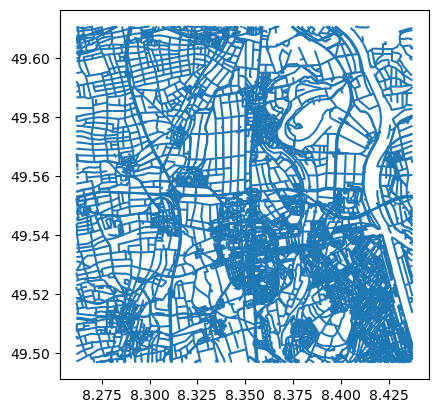

In [40]:
print(len(response_gdf))
response_gdf.plot()

## Rasterization and conversion to tensor

In [109]:
def convert_to_tensor(gdf, area_coords: Tuple[float, float, float, float], resolution=(.0001, .0001)):

    minx, miny, maxx, maxy = area_coords
    shape = (int((maxy-miny)/resolution[0]), int((maxx-minx)/resolution[1]))
    transform = rio.transform.from_origin(minx, maxy, *resolution)

    print(shape, transform)

    raster_data = rasterize(((geom, 1) for geom in gdf.geometry), out_shape=shape, transform=transform)

    return torch.from_numpy(raster_data)

In [112]:
tensor_data = convert_to_tensor(response_gdf, area_coords)
print(tensor_data, tensor_data.dtype)

(1140, 1757) | 0.00, 0.00, 8.26|
| 0.00,-0.00, 49.61|
| 0.00, 0.00, 1.00|
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8) torch.uint8


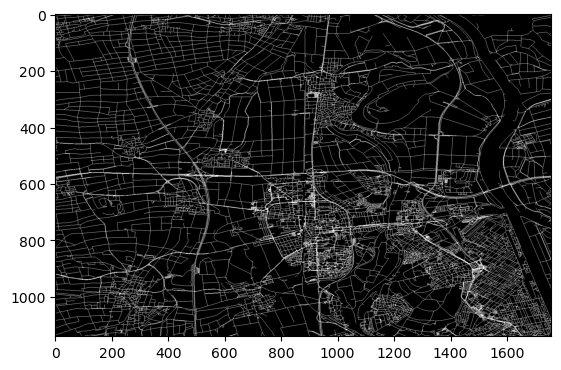

In [113]:
plt.imshow(tensor_data, cmap='gray')
plt.show()

## Rasterization and reshaping with Geocube

In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
from geocube.api.core import make_geocube
from rasterio.enums import Resampling
import rasterio.features
from shapely import wkt
from shapely.geometry import box

In [7]:
target_size = (1257, 1278)

resolution=(.0001, .0001)

utm = 'EPSG:25832'

gdf = response_gdf.copy()

In [220]:
extent = gpd.GeoDataFrame(index=['extent'],
                                crs='epsg:4326',
                                geometry=[box(*area_coords, ccw=True)])
# Add value col with binary values
gdf['value'] = 1
extent['value'] = 0

vector_data = pd.concat([gdf, extent], ignore_index=True)

In [49]:
def rasterize(area_coords, gdf, utm, target_size, val_col='value', resolution=(.0001, .0001)) -> np.ndarray:
    # Calculate extent from bbox
    extent = gpd.GeoDataFrame(index=['extent'],
                                crs='epsg:4326',
                                geometry=[box(*area_coords, ccw=True)])
    # Add value col with binary values
    gdf['value'] = 1
    extent['value'] = 0

    # Extend df with extent
    vector_data = pd.concat([gdf, extent], ignore_index=True)

    # Sort by descending area to stack road network (smaller) on top of background (larger)
    sorted_desc_areas_idx = vector_data.copy().to_crs(utm).geometry.area.argsort()[::-1]

    # Create geocube (xarray.Dataset) from gdf
    geocube = make_geocube(
        vector_data=vector_data.iloc[sorted_desc_areas_idx],
        measurements=['value'],
        resolution=resolution,
        output_crs='EPSG:4326',
        fill=0
    ).astype(np.uint8)

    # Resample geocube values (xarray.DataArray) to target_size from imagery
    resampled_raster = geocube[val_col].rio.reproject(geocube[val_col].rio.crs, shape=target_size, resampling=Resampling.bilinear)

    # Add channel count as third dimension
    # return np.expand_dims(resampled_raster, axis=-1)
    return resampled_raster

In [50]:
raster = rasterize(area_coords, gdf, utm, target_size)
raster.shape

(1257, 1278)

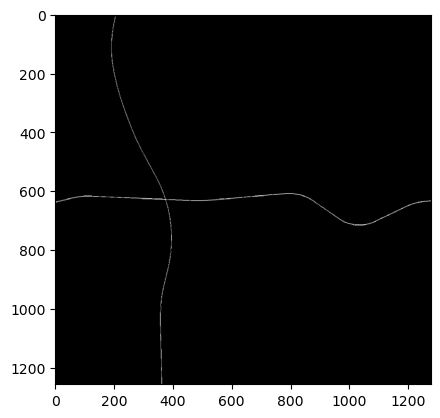

In [51]:
plt.imshow(raster, cmap='gray')
plt.show()

### Single calls from function

In [224]:
sorted_desc_areas_idx = vector_data.copy().to_crs(utm).geometry.area.argsort()[::-1]

# Create geocube from gdf
geocube = make_geocube(
    vector_data=vector_data.iloc[sorted_desc_areas_idx],
    measurements=['value'],
    resolution=resolution,
    output_crs='EPSG:4326',
    fill=0
).astype(np.uint8)

geocube

<xarray.Dataset>
Dimensions:      (y: 1142, x: 1758)
Coordinates:
  * y            (y) float64 49.5 49.5 49.5 49.5 ... 49.61 49.61 49.61 49.61
  * x            (x) float64 8.262 8.262 8.262 8.262 ... 8.437 8.437 8.437 8.437
    spatial_ref  int64 0
Data variables:
    value        (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [228]:
gc_array = geocube['value']
gc_array

<xarray.DataArray 'value' (y: 1142, x: 1758)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y            (y) float64 49.5 49.5 49.5 49.5 ... 49.61 49.61 49.61 49.61
  * x            (x) float64 8.262 8.262 8.262 8.262 ... 8.437 8.437 8.437 8.437
    spatial_ref  int64 0
Attributes:
    name:        value
    long_name:   value
    _FillValue:  0

In [229]:
resampled_raster = gc_array.rio.reproject(gc_array.rio.crs, shape=target_size, resampling=Resampling.bilinear)
resampled_raster

<xarray.DataArray 'value' (y: 1257, x: 1278)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x            (x) float64 8.262 8.262 8.262 8.262 ... 8.437 8.437 8.437 8.437
  * y            (y) float64 49.61 49.61 49.61 49.61 ... 49.5 49.5 49.5 49.5
    spatial_ref  int64 0
Attributes:
    name:        value
    long_name:   value
    _FillValue:  0

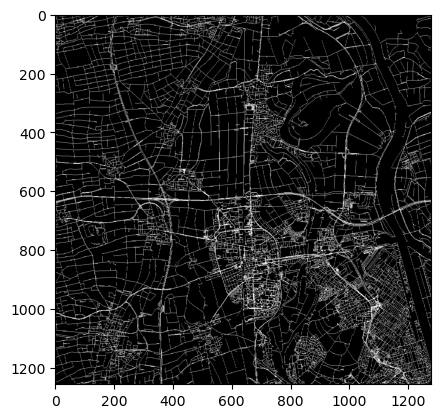

In [230]:
plt.imshow(resampled_raster, cmap='gray')
plt.show()

In [231]:
resampled_raster.shape

(1257, 1278)

In [232]:
resampled_raster_dim = np.expand_dims(resampled_raster, axis=-1)
resampled_raster_dim.shape

(1257, 1278, 1)

## One-hot encoding road types

In [9]:
def preprocess(response: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """This static method preprocesses the response from the ohsome API.

    :param response: gpd.GeoDataFrame with raw road network data

    :return: gpd.GeoDataFrame with preprocessed road network data
    """

    # Remove all non (Multi-)LineString geometries (primarily relics/false geometries)
    roads_linestrings = response[response['geometry'].astype(object).apply(lambda geom: isinstance(geom, (LineString, MultiLineString)))]

    # Break up multi-index
    roads_linestrings.reset_index(inplace=True)
    if roads_linestrings['@osmId'].is_unique:
        roads_linestrings = roads_linestrings.set_index('@osmId')

    # Replace "unclassified" roads with "road" tag
    roads_linestrings['highway'] = roads_linestrings['highway'].replace('unclassified', 'road')

    # Read road network tag asset
    with open(data_dir / './assets/road_network_tags.yaml', 'r') as src:
        yaml_content = yaml.safe_load(src)
        tags_list = yaml_content['tags']
        road_types_list = yaml_content['highway']

    # Only keep cols specified in road_network_tags.yaml
    tags = [tag.strip() for tag in tags_list]
    tags_to_keep = [col for col in tags if col in roads_linestrings.columns]

    roads_linestrings = roads_linestrings[tags_to_keep]

    # Return only road types specified in road_network_tags.yaml
    return roads_linestrings[roads_linestrings['highway'].isin(road_types_list)]

In [10]:
road_network = preprocess(response_gdf)
print(len(response_gdf.columns), len(road_network.columns))
print(len(response_gdf), len(road_network))

258 14
13455 13303


In [11]:
road_types_list = road_network[['geometry', 'highway']]

In [12]:
print(len(road_types_list['highway'].value_counts()))
road_types_list['highway'].value_counts().sort_index()

18


highway
cycleway            35
footway           1745
living_street      444
motorway           173
motorway_link      105
path              1292
pedestrian          38
primary             48
residential       1739
road               689
secondary          399
secondary_link      15
service           3679
tertiary           486
tertiary_link        8
track             2030
trunk              215
trunk_link         163
Name: count, dtype: int64

In [13]:
with open(data_dir / './assets/road_network_tags.yaml', 'r') as src:
    yaml_content = yaml.safe_load(src)
    road_types_list = yaml_content['highway']

In [52]:
from sklearn.preprocessing import OneHotEncoder

def encode_road_types(road_types_list, road_network: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """This static method one-hot encodes the road types in the road network data.
    
    :param road_network: gpd.GeoDataFrame with road network data

    :return: gpd.GeoDataFrame with one-hot encoded road types
    """
    # One-hot encode the 'highway' column
    ohe = OneHotEncoder(sparse_output=False, dtype=np.uint8)
    ohe.fit(pd.DataFrame(road_types_list, columns=['highway']))  # Fit on all possible road types
    ohe_encoded = ohe.transform(road_network[['highway']])  # Transform the current road network

    # Create a DataFrame from the encoded data
    road_network[ohe.categories_[0]] = ohe_encoded

    print(ohe_encoded.dtype)

    return road_network

In [53]:
road_network_types_encoded = encode_road_types(road_types_list, road_network)

uint8


In [54]:
len(road_network_types_encoded)

13303

In [55]:
road_network_types_encoded['motorway'].value_counts().sort_index()

motorway
0    13130
1      173
Name: count, dtype: int64

In [56]:
print(len(road_network_types_encoded.columns))
road_network_types_encoded.columns

34


Index(['access', 'access:conditional', 'agricultural', 'est_width', 'geometry',
       'highway', 'lanes', 'maxspeed', 'maxspeed:type', 'restriction',
       'source:maxspeed', 'width', 'zone:maxspeed', 'zone:traffic',
       'bridleway', 'cycleway', 'footway', 'living_street', 'motorway',
       'motorway_link', 'path', 'pedestrian', 'primary', 'primary_link',
       'residential', 'road', 'secondary', 'secondary_link', 'service',
       'tertiary', 'tertiary_link', 'track', 'trunk', 'trunk_link'],
      dtype='object')

In [57]:
# Initialize an empty 3D numpy array
rasterized_road_network = np.empty((target_size[0], target_size[1], len(road_types_list)))

# Iterate through road type columns (skip geometry)
for i, road_type in enumerate(road_types_list):
    gdf = road_network_types_encoded.loc[road_network_types_encoded[road_type] != 0, ['geometry', road_type]]
    # Rasterize road type gdf and add to the corresponding band of the raster
    rasterized_road_network[:, :, i] = rasterize(area_coords, gdf, utm, target_size)

In [60]:
rasterized_road_network

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [43]:
rasterized_road_network['trunk'].shape

(1257, 1278, 1)

In [44]:
np.unique(rasterized_road_network['path'], return_counts=True)

(array([0, 1], dtype=uint8), array([1590244,   16202]))

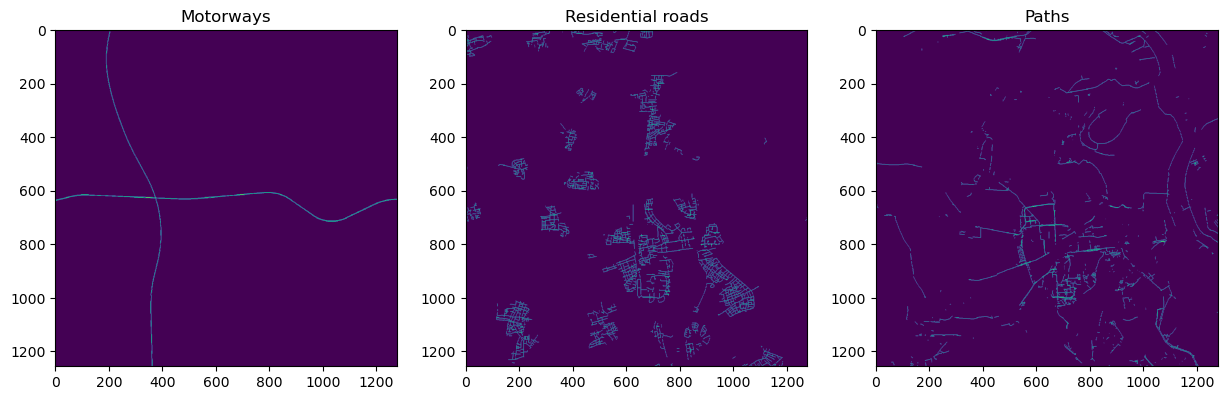

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 'motorways'
axs[0].imshow(rasterized_road_network['motorway'])
axs[0].set_title('Motorways')

# Plot 'residential'
axs[1].imshow(rasterized_road_network['residential'])
axs[1].set_title('Residential roads')

# Plot 'path'
axs[2].imshow(rasterized_road_network['path'])
axs[2].set_title('Paths')

# Display the figure
plt.show()

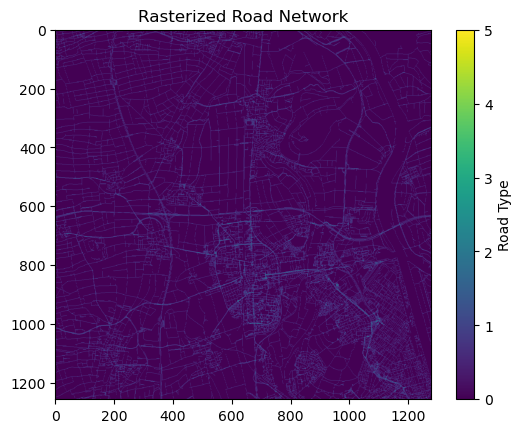

In [46]:
import numpy as np

# Combine the image arrays
combined_image = np.sum(list(rasterized_road_network.values()), axis=0)

# Plot the combined image
plt.imshow(combined_image, cmap='viridis')
plt.colorbar(label='Road Type')
plt.title('Rasterized Road Network')
plt.show()

## Lanebased buffer

In [66]:
def highways_lanebuffer(road_network):
    """Apply dynamic buffer to motorways and trunks based on lane count."""

    def add_lanebased_buffer(row):
        # Data from FGSV.2011 - max width values for EKA 1 roads if not specified otherwise
        if row['lanes'] == '2' and row['highway'] in ('motorway_link', 'trunk_link'):
            value = 9.5
        elif row['lanes'] == '2' and row['highway'] == 'trunk': # EKA 2
            value = 28 / 2
        elif row['lanes'] == '2' and row['highway'] == 'motorway':
            value = 31 / 2
        elif row['lanes'] == '3': # Connectors with > 2 lanes not possible in Germany -> regulations
            value = 36 / 2
        elif row['lanes'] == '4':
            value = 43.5 / 2
        else: # If lanes == nan or 1 (motorways/trunks with 1 lane not possible in Germany -> regulations)
            return row['geometry'].buffer(6) # Single connector lane width
        return row['geometry'].buffer(value)

    # Apply the buffer only to the rows that are highways
    highways_mask = road_network['highway'].isin(['motorway', 'motorway_link', 'trunk', 'trunk_link'])
    road_network.loc[highways_mask, 'geometry'] = road_network.loc[highways_mask].apply(add_lanebased_buffer, axis=1)

    return road_network

LineString         13452
MultiLineString        3
dtype: int64


<Axes: >

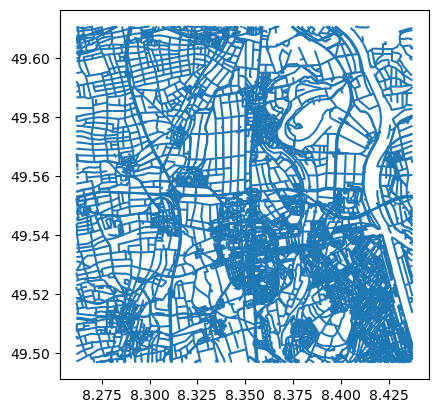

In [67]:
print(response_gdf.geometry.type.value_counts())
response_gdf.plot()

In [68]:
roads_buffered = response_gdf.copy()

In [69]:
roads_buffered.to_crs(25832, inplace=True)
roads_buffered = highways_lanebuffer(roads_buffered)

LineString         12796
Polygon              656
MultiLineString        3
dtype: int64


<Axes: >

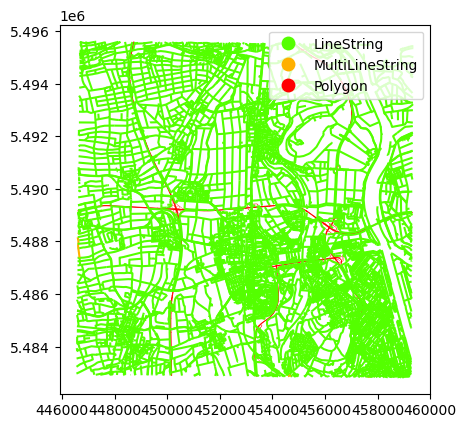

In [77]:
print(roads_buffered.geometry.type.value_counts())
# Create a new column 'geometry_type' that represents the geometry type of each row
roads_buffered['geometry_type'] = roads_buffered.geometry.type

# Plot the GeoDataFrame using the 'geometry_type' column for colors
roads_buffered.plot(column='geometry_type', legend=True, cmap='prism_r')